<a href="https://colab.research.google.com/github/ilham-mukti/Mencoba-Neural-Network/blob/main/CNN_Multiclass_Transfer_Learning_Kue_Indonesia_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jcopdl

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16925 sha256=879e3c7c34f839786ed9d80056eebf5dcafd78fd670a8f622043add064627837
  Stored in directory: /root/.cache/pip/wheels/bb/fd/9d/fc72bcf569000eabd487e654fdf55b587e66882b60eaa5693b
Successfully built jcopdl


In [2]:
!pip install kaggle

In [5]:
!cp /content/kaggle.json /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d ilhamfp31/kue-indonesia

 95% 289M/303M [00:05<00:00, 54.3MB/s]
100% 303M/303M [00:06<00:00, 53.0MB/s]


In [ ]:
!unzip /content/kue-indonesia.zip

In [26]:
import torch
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block, conv_block
from jcopdl.utils.dataloader import MultilabelDataset

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [27]:
bs = 128
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_set = datasets.ImageFolder("/content/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("/content/validation/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [40]:
label2cat = train_set.classes
label2cat

['kue_dadar_gulung',
 'kue_kastengel',
 'kue_klepon',
 'kue_lapis',
 'kue_lumpur',
 'kue_putri_salju',
 'kue_risoles',
 'kue_serabi']

In [29]:
class CustomMobileNetv2(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.mnet = mobilenet_v2(pretrained=True)
    self.freeze()

    self.mnet.classifier = nn.Sequential(
        nn.Linear(1280, output_size),
        nn.LogSoftmax()
    )

  def forward(self, x):
    return self.mnet(x)
  
  def freeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = False

  def unfreeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = True

In [30]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size,
    'output_size': len(train_set.classes)
})

In [31]:
model = CustomMobileNetv2(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir='model')

In [32]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  
  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost/len(dataset)
  acc = correct/len(dataset)
  return cost, acc

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)




Epoch     1
Train_cost  = 1.6475 | Test_cost  = 1.1447 | Train_score = 0.5099 | Test_score = 0.8250 |




Epoch     2
Train_cost  = 0.9074 | Test_cost  = 0.7362 | Train_score = 0.8483 | Test_score = 0.8688 |




Epoch     3
Train_cost  = 0.6317 | Test_cost  = 0.5611 | Train_score = 0.8687 | Test_score = 0.8938 |




Epoch     4
Train_cost  = 0.4907 | Test_cost  = 0.4845 | Train_score = 0.8951 | Test_score = 0.8938 |
==> EarlyStop patience =  1 | Best test_score: 0.8938




Epoch     5
Train_cost  = 0.4256 | Test_cost  = 0.4411 | Train_score = 0.9050 | Test_score = 0.9000 |




Epoch     6
Train_cost  = 0.3922 | Test_cost  = 0.4018 | Train_score = 0.9083 | Test_score = 0.9125 |




Epoch     7
Train_cost  = 0.3589 | Test_cost  = 0.3842 | Train_score = 0.9169 | Test_score = 0.9250 |




Epoch     8
Train_cost  = 0.3243 | Test_cost  = 0.3631 | Train_score = 0.9202 | Test_score = 0.9125 |
==> EarlyStop patience =  1 | Best test_score: 0.9250




Epoch     9
Train_cost  = 0.3043 | Test_cost  = 0.3396 | Train_score = 0.9182 | Test_score = 0.9187 |
==> EarlyStop patience =  2 | Best test_score: 0.9250
==> Execute Early Stopping at epoch: 9 | Best test_score: 0.9250
==> Best model is saved at model


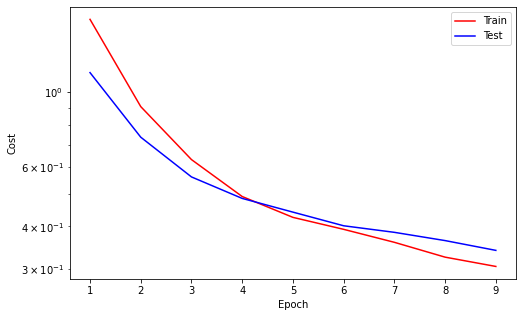

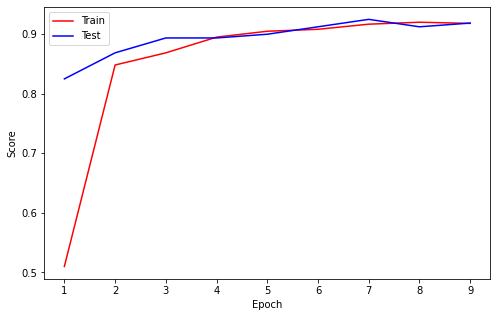

In [33]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

In [34]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)




Epoch    10
Train_cost  = 0.3155 | Test_cost  = 0.3449 | Train_score = 0.9307 | Test_score = 0.9250 |
==> EarlyStop patience =  1 | Best test_score: 0.9250




Epoch    11
Train_cost  = 0.2647 | Test_cost  = 0.3194 | Train_score = 0.9426 | Test_score = 0.9313 |




Epoch    12
Train_cost  = 0.2380 | Test_cost  = 0.2992 | Train_score = 0.9466 | Test_score = 0.9250 |
==> EarlyStop patience =  1 | Best test_score: 0.9313




Epoch    13
Train_cost  = 0.2163 | Test_cost  = 0.2828 | Train_score = 0.9545 | Test_score = 0.9250 |
==> EarlyStop patience =  2 | Best test_score: 0.9313




Epoch    14
Train_cost  = 0.1962 | Test_cost  = 0.2702 | Train_score = 0.9532 | Test_score = 0.9313 |
==> EarlyStop patience =  3 | Best test_score: 0.9313




Epoch    15
Train_cost  = 0.1774 | Test_cost  = 0.2603 | Train_score = 0.9624 | Test_score = 0.9313 |
==> EarlyStop patience =  4 | Best test_score: 0.9313




Epoch    16
Train_cost  = 0.1567 | Test_cost  = 0.2529 | Train_score = 0.9710 | Test_score = 0.9313 |
==> EarlyStop patience =  5 | Best test_score: 0.9313
==> Execute Early Stopping at epoch: 16 | Best test_score: 0.9313
==> Best model is saved at model


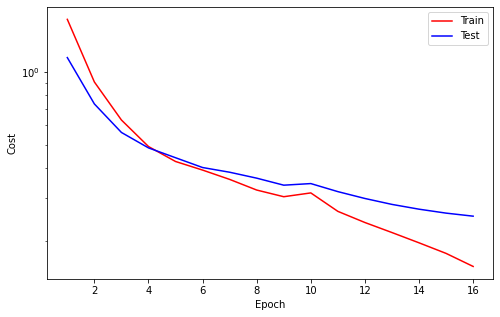

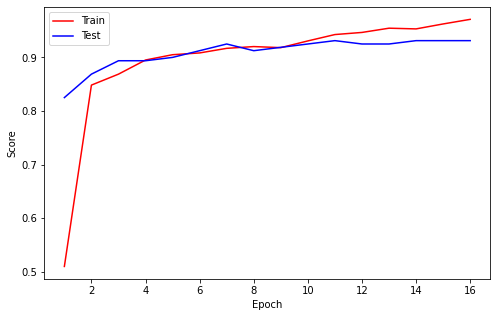

In [35]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

In [36]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [37]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = output.argmax(1)
preds

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([4, 1, 6, 0, 7, 5, 1, 5, 0, 1, 4, 6, 6, 2, 6, 6, 1, 5, 3, 2, 0, 2, 1, 4,
        6, 7, 7, 3, 5, 2, 2, 0, 1, 0, 5, 2, 3, 7, 4, 5, 2, 5, 7, 2, 7, 1, 5, 3,
        6, 2, 3, 7, 7, 3, 6, 3, 7, 5, 4, 7, 3, 4, 3, 6, 1, 2, 1, 1, 6, 5, 1, 3,
        0, 5, 0, 6, 0, 3, 4, 2, 6, 5, 7, 2, 3, 3, 7, 0, 1, 4, 0, 0, 1, 6, 3, 2,
        0, 0, 0, 4, 6, 0, 3, 5, 5, 2, 0, 1, 7, 1, 1, 6, 2, 5, 0, 4, 4, 0, 0, 6,
        6, 4, 1, 2, 4, 4, 2, 6], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

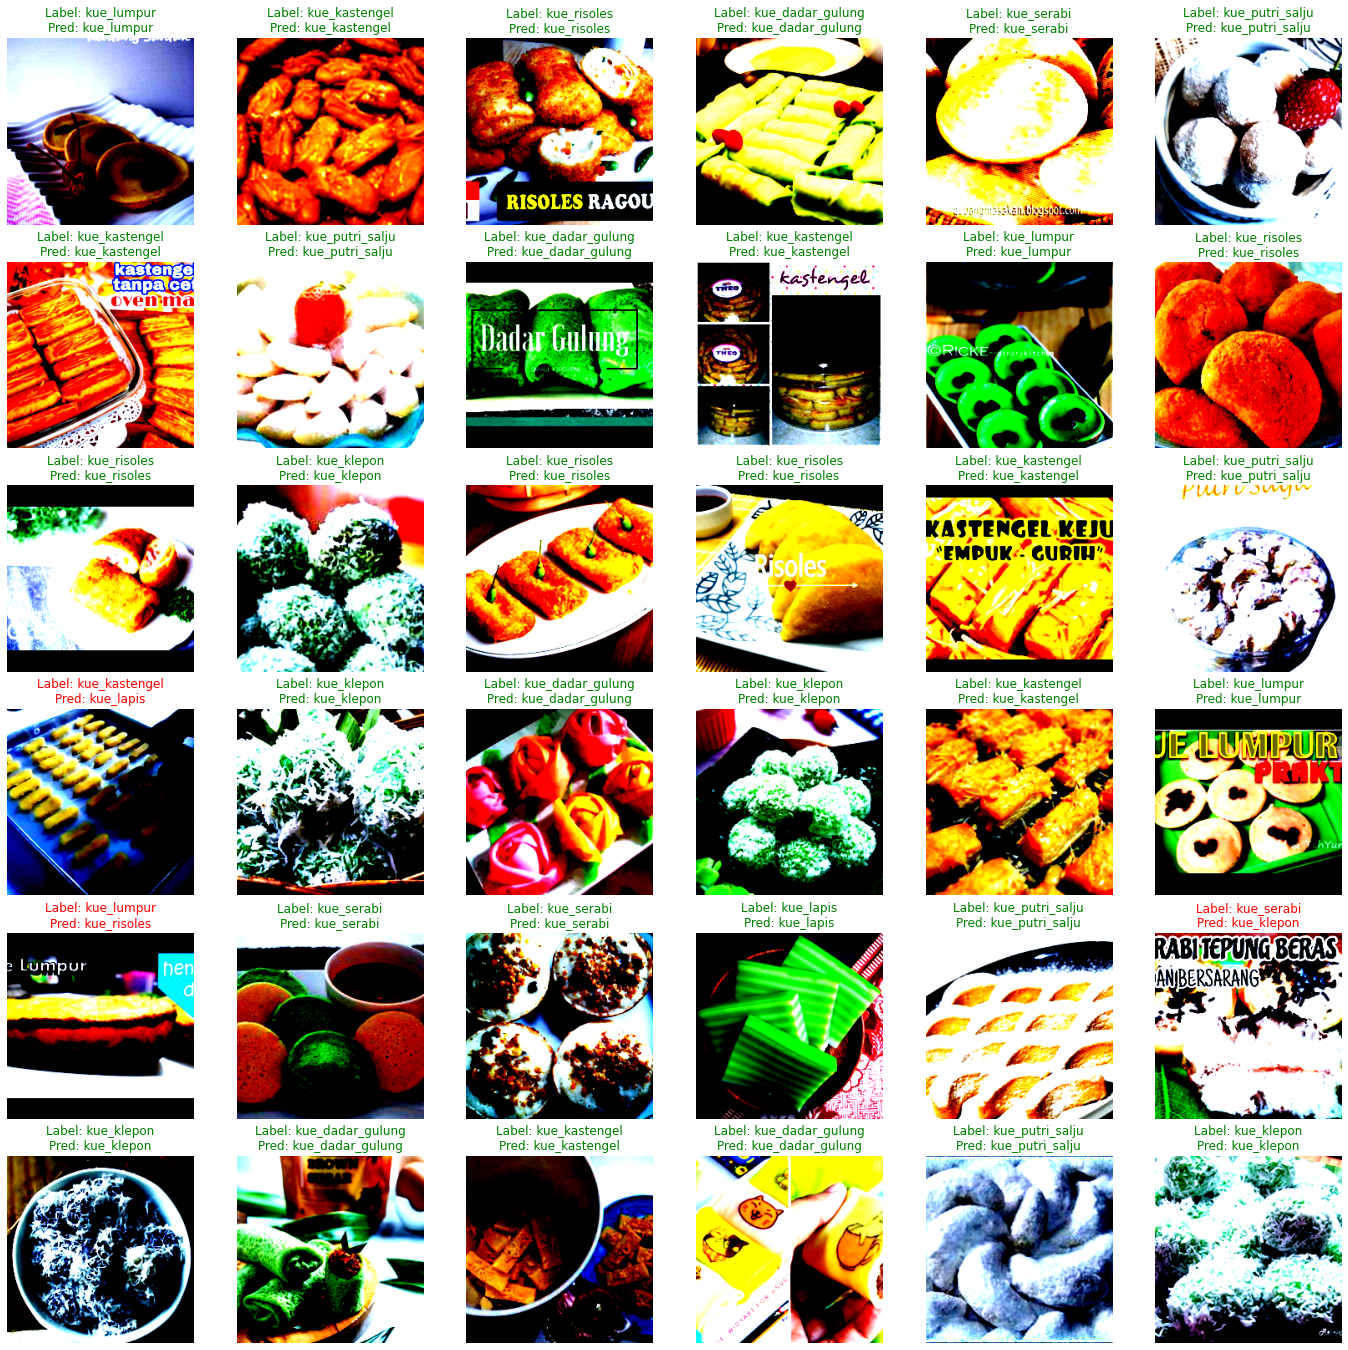

In [42]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(img.permute(1,2,0).cpu())
  font = {"color":'r'} if label != pred else {"color": 'g'}
  label, pred = label2cat[label.item()], label2cat[pred.item()]
  ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font);
  ax.axis("off");

In [43]:
from PIL import Image

In [62]:
imsize = 224
loader = transforms.Compose([transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    #image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image.cuda()

image = image_loader("/content/test/kue_putri_salju/1.jpg")
with torch.no_grad():
  model.eval()
  output = model(image)
  prediksi = output.argmax(1)
  print(label2cat[prediksi])

kue_putri_salju


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
